# Part 3 NLP Classification Task

This part is trying to use review title and review body to predict the ratings of this review.

Our goal is to built a model based on pre-trained BERT model (the encoder part of the Transformers) to predict the ratings

## Dependencies

In [1]:
# Basic packages
import os, pdb, sys
import random
import numpy as np
import pandas as pd
import re
from tqdm import tqdm as progress_bar
import ipywidgets
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# data proprocess
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [3]:
# tf-idf related model
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [4]:
# torch related
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

In [5]:
# transformers
from transformers import BertModel, BertConfig
from transformers import AdamW, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
from transformers import BertTokenizer

In [6]:
# evaluations
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [65]:
# helper function
def plot_cm(y_test, y_test_pred, name, labels=[1, 2, 3, 4, 5]):
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_df, annot=True, cmap=plt.get_cmap('Blues'), fmt="d")
    plt.title("Confusion Matrix of " + name)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

def extract_positive_negative(y_test, y_test_pred):
    # from the labels of 0, 1, 3, 4: return the positive / negative list
    y_test = np.array(y_test)
    y_test_pred = np.array(y_test_pred)
    
    negative_index = y_test < 2
    positive_index = y_test > 2
    
    y_test_pn = np.array([0]*negative_index.sum() + [1]*positive_index.sum())
    pred_neg = np.logical_not(y_test_pred[negative_index] <= 2)*1
    pred_pos = (y_test_pred[positive_index] >= 2)*1
    y_pred_pn = np.concatenate([pred_neg, pred_pos])
    return y_test_pn, y_pred_pn

### Some Constants

In [8]:
np.random.seed(42)

In [9]:
torch.set_float32_matmul_precision('high') # trade precision for performance

In [10]:
max_len = 256 # maximum sequence length to look back
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
dropout = 0.5
learning_rate = 1e-6

## Basic Data

In [11]:
# load data
filepath = os.path.join('data', 'amazon_reviews_us_Electronics_v1_00.tsv')
raw_data = pd.read_csv(filepath, delimiter='\t', on_bad_lines='skip')

In [12]:
data = raw_data[['review_body', 'star_rating', 'review_headline']].dropna()
data['review'] = data['review_headline'] + ', ' + data['review_body'] 
data['review'] = data['review'].str.lower()
data.drop(columns=['review_body', 'review_headline'], inplace = True)
data = data[data['review'].str.len() >= 100]
del raw_data

In [13]:
one = data[data['star_rating'] == 1]
two = data[data['star_rating'] == 2]
three = data[data['star_rating'] == 3]
four = data[data['star_rating'] == 4]
five = data[data['star_rating'] == 5]

In [14]:
# used a portion of data for efficiency & balance the data
data = pd.concat([one.sample(15000), two.sample(15000), three.sample(15000), four.sample(15000), five.sample(15000)])

# shuffle the data
data = data.sample(frac=1)

train_data = data.iloc[: round(len(data) * 0.8)]
valid_data = data.iloc[round(len(data) * 0.8) : round(len(data) * 0.9)]
test_data = data.iloc[round(len(data) * 0.9) :]

In [15]:
# release memory
del(one)
del(two)
del(three)
del(four)
del(five)

## Sub-Part (a): TF-IDF with Logistic Regression
We will train a TF-IDF model as a baseline model.

### Prepare Train Test Data

In [80]:
X_train, y_train = train_data['review'], train_data['star_rating']
X_test, y_test = test_data['review'], test_data['star_rating']

### Setup the Model and Train

In [81]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(decode_error='ignore')),
    ('SVD', TruncatedSVD(100)),
    ('log_clf', LogisticRegression(n_jobs = 4))
])

In [82]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(decode_error='ignore')),
                ('SVD', TruncatedSVD(n_components=100)),
                ('log_clf', LogisticRegression(n_jobs=4))])

### Evaluate the Result

In [83]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [84]:
# test acc
accuracy_score(y_test, y_test_pred)

0.5057333333333334

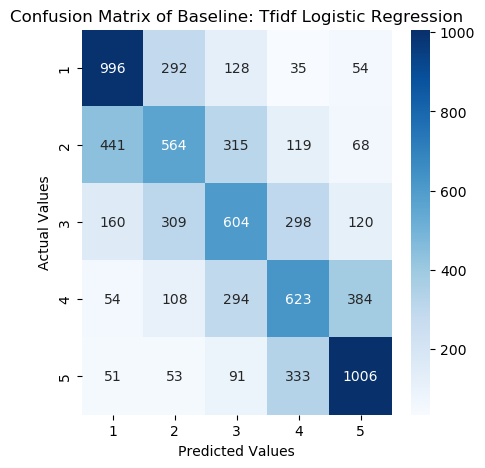

In [85]:
plot_cm(y_test, y_test_pred, "Baseline: Tfidf Logistic Regression")

### Reframe Problem into Binary Classification: Sentiment

In [86]:
y_test_pn, y_pred_pn = extract_positive_negative(y_test, y_test_pred)

In [87]:
accuracy_score(y_test_pn, y_pred_pn)

0.9195728349741364

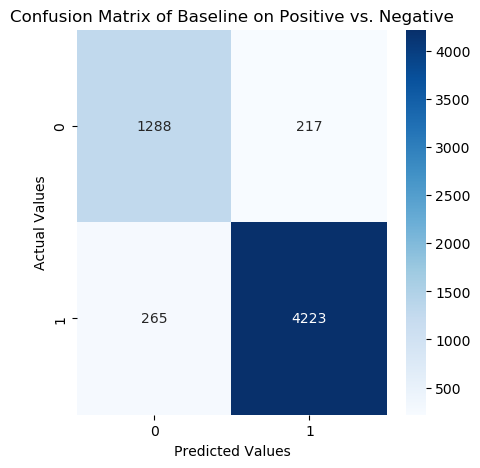

In [88]:
plot_cm(y_test_pn, y_pred_pn, "Baseline on Positive vs. Negative", [0, 1])

## Sub-Part (b): BERT

### Prepare DataLoader

In [26]:
class Review_dataset(Dataset):
    def __init__(self, dataframe, tokenizer):

        self.labels = (dataframe['star_rating']).to_numpy() - 1

        self.texts = []
        print("Tokenizing the data")
        for sentence in progress_bar(dataframe['review']):
            self.texts.append(tokenizer(sentence, padding = 'max_length', max_length = max_len, truncation = True, 
                                       return_tensors='pt'))

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return self.labels[idx]

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_texts.convert_to_tensors(), torch.tensor(batch_labels)

In [27]:
# prepare tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [28]:
# train dataloader
train_dataset = Review_dataset(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
# validation dataloader
valid_dataset = Review_dataset(valid_data, tokenizer)
valid_dataloader = DataLoader(valid_dataset, sampler=SequentialSampler(valid_dataset), batch_size=batch_size)
# test dataloader
test_dataset = Review_dataset(test_data, tokenizer)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

Tokenizing the data


100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [01:18<00:00, 767.09it/s]


Tokenizing the data


100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:09<00:00, 796.83it/s]


Tokenizing the data


100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:09<00:00, 763.69it/s]


### PyTorch Lightning Model

In [29]:
class Review_Net(pl.LightningModule):
    """
    Review Net is built as a classification network.
    
    It use pretrained BERT as decoder of one sentence, and use two fully 
    layers to connect to the output part. This is used for classification.
    
    Inputs:
        
    
    """
    def __init__(self):
        super().__init__()

        # bert encoder part
        self.encoder = BertModel.from_pretrained("bert-base-uncased")
        
        self.dropout = nn.Dropout(dropout)

#         for param in self.encoder.parameters():
#             # don't train pre-trained BERT
#             param.requires_grad = False
        
        # classifier part
        self.fc = nn.Linear(768, 1024)
        self.output = nn.Linear(1024, 5)
        
    def forward(self, input_id, mask):
        
        # bert encoder
        _, pooled_output = self.encoder(input_ids = input_id, attention_mask=mask, return_dict = False)
        
        # dropout
        dropout_output = self.dropout(pooled_output)
        
        # output layer
        vector = nn.ReLU()(self.fc(dropout_output))
        pred = self.output(vector)
        
        return pred
    
    def training_step(self, batch, batch_index):
        # training loop
    
        texts, labels = batch
        input_id = texts['input_ids'].squeeze(1)
        mask = texts['attention_mask']
        
        logits = self(input_id, mask)
        
        loss = nn.CrossEntropyLoss()(logits, labels.long())
        self.log("train_loss", loss)
        
        acc = (logits.argmax(dim=1) == labels).float().mean().item()
        self.log('train_accuracy', acc)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
    
    def validation_step(self, batch, batch_index):
        texts, labels = batch
        input_id = texts['input_ids'].squeeze(1)
        mask = texts['attention_mask']
        
        logits = self(input_id, mask)
        
        loss = nn.CrossEntropyLoss()(logits, labels.long())
        self.log("valid_loss", loss)
        
        acc = (logits.argmax(dim=1) == labels).float().mean().item()
        self.log('valid_accuracy', acc)
        
        return loss
    
    def test_step(self, batch, batch_index):
        texts, labels = batch
        input_id = texts['input_ids'].squeeze(1)
        mask = texts['attention_mask']
        
        logits = self(input_id, mask)
        
        loss = nn.CrossEntropyLoss()(logits, labels.long())
        self.log("test_loss", loss)
        return loss

### Model Setup

In [30]:
# set up the early stopping 
early_stop_callback = EarlyStopping(monitor='valid_loss', patience=10, mode="min")

In [31]:
# set up the logger
logger = TensorBoardLogger(save_dir='lightning_logs/')

In [32]:
bert_model = Review_Net()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
trainer = pl.Trainer(max_epochs=50, devices=1, accelerator='gpu', callbacks=[early_stop_callback], logger=logger, 
                     val_check_interval=0.2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [34]:
%%time
trainer.fit(bert_model, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | encoder | BertModel | 109 M 
1 | dropout | Dropout   | 0     
2 | fc      | Linear    | 787 K 
3 | output  | Linear    | 5.1 K 
--------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
441.099   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

CPU times: total: 4h 22min 42s
Wall time: 4h 23min 34s


### Evaluate the Result

In [35]:
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8682119250297546
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8682119250297546}]

In [36]:
with torch.no_grad():
    bert_model = bert_model.cuda()
    
    preds_lst = []
    labels_lst = []
    
    for test_input, test_label in test_dataloader:

        test_label = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)

        output = bert_model(input_id, mask).argmax(dim=1)
        for pred, label in zip(output, test_label):
            preds_lst.append(pred.item())
            labels_lst.append(label.item())

In [37]:
accuracy_score(labels_lst, preds_lst)

0.6261333333333333

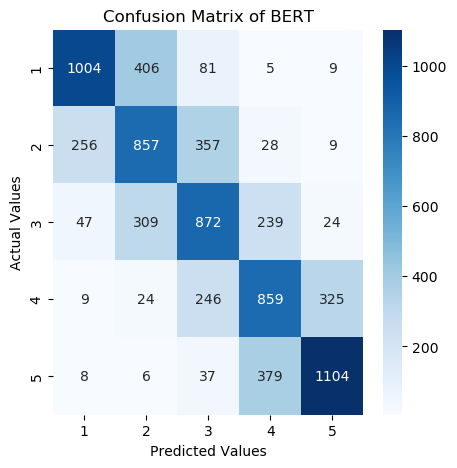

In [38]:
plot_cm(labels_lst, preds_lst, "BERT")

### Reframe Problem into Binary Classification: Sentiment

In [71]:
test_pn, pred_pn = extract_positive_negative(labels_lst, preds_lst)

In [72]:
accuracy_score(y_test_pn, y_pred_pn)

0.9834095141357712

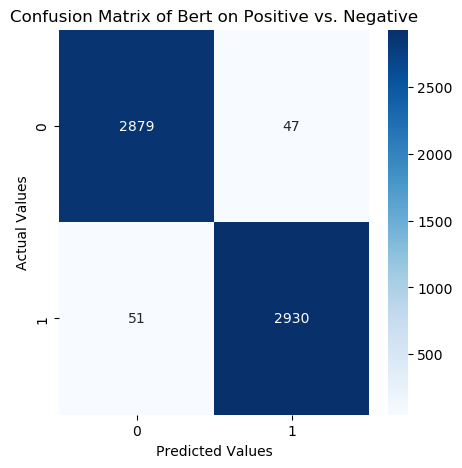

In [73]:
plot_cm(y_test_pn, y_pred_pn, 'Bert on Positive vs. Negative', [0, 1])